## Netflix Data Visualization Project

In [9]:
##
#Let's start by creating the Python script for the main analysis
# Firstly, We import the essential libraries such as pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for visualizations, zipfile for extracting compressed files, warnings to suppress unnecessary warnings etc


# netflix_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [12]:
# Data Preparation
# Here, The unzip_and_load_data() function extracts the dataset from a ZIP file into the 'netflix_data' folder using Python's built-in zipfile module. 
# It then automatically detects CSV files for loading, and then rename_dataset() symbolically renames the dataset as requested.



def unzip_and_load_data(zip_path):
    """
    Unzip the dataset and load it into a pandas DataFrame
    """
    try:
        # Extracting the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('netflix_data')
            print("Files extracted:", zip_ref.namelist())
        
        # Looking for CSV files in the extracted folder
        csv_files = [f for f in os.listdir('netflix_data') if f.endswith('.csv')]
        
        if csv_files:
            # Here, we load the first CSV file found
            file_path = os.path.join('netflix_data', csv_files[0])
            df = pd.read_csv(file_path)
            print(f"Loaded dataset: {csv_files[0]}")
            return df
        else:
            print("No CSV files found in the zip archive")
            return None
            
    except Exception as e:
        print(f"Error extracting or loading data: {e}")
        return None

def rename_dataset(df, Netflix_shows_movies):
    """
    Rename the dataset (this primarily means we'll save it with the new name)
    """
    # Thus, we will create a copy with the desired name reference
    print(f"Dataset renamed to: {Netflix_shows_movies}")
    return df

In [14]:
## Data Cleaning Stage
# Thus, we first examine the extent of missing data
# Meaning different strategies for different data types:
# Numerical columns: Fill with median (better than mean for skewed data)
# Categorical columns: Fill with mode (most frequent value) if few missing values, otherwise use 'Unknown'
# This approach prevents bias in our analysis while maintaining data integrity


def clean_data(df):
    """
    Address missing values and perform data cleaning
    """
    print("Original dataset shape:", df.shape)
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())
    
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Here, we handle missing values based on column type and importance
    for column in df_clean.columns:
        missing_count = df_clean[column].isnull().sum()
        missing_percent = (missing_count / len(df_clean)) * 100
        
        print(f"\n{column}: {missing_count} missing values ({missing_percent:.2f}%)")
        
        # Strategy for handling missing values:
        if missing_count > 0:
            if df_clean[column].dtype in ['float64', 'int64']:
                # For numerical columns, fill with median (less sensitive to outliers)
                df_clean[column].fillna(df_clean[column].median(), inplace=True)
                print(f"  → Filled with median: {df_clean[column].median()}")
            elif df_clean[column].dtype == 'object':
                # For categorical columns, fill with mode (most frequent value)
                if missing_percent < 5:  # If less than 5% missing
                    mode_value = df_clean[column].mode()[0] if not df_clean[column].mode().empty else 'Unknown'
                    df_clean[column].fillna(mode_value, inplace=True)
                    print(f"  → Filled with mode: {mode_value}")
                else:
                    # If too many missing values, create 'Unknown' category
                    df_clean[column].fillna('Unknown', inplace=True)
                    print(f"  → Filled with 'Unknown'")
    
    print("\nMissing values after cleaning:")
    print(df_clean.isnull().sum())
    
    return df_clean

In [17]:
## For Data Exploration
# We first utilize "explore_data()" which gives us a comprehensive overview of our dataset
# We then examine shape, data types, statistical summaries, and value distributions
# And employ "detect_netflix_columns()" to automatically identify common Netflix dataset columns since column names might vary
# This exploratory analysis helps us understand what insights we can extract


def explore_data(df):
    """
    Perform comprehensive data exploration and statistical analysis
    """
    print("=" * 50)
    print("DATA EXPLORATION SUMMARY")
    print("=" * 50)
    
    # Basic dataset information
    print(f"Dataset Shape: {df.shape}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    # Column information
    print("\nColumn Information:")
    print(df.info())
    
    # Statistical summary for numerical columns
    print("\nStatistical Summary (Numerical Columns):")
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(df[numerical_cols].describe())
    else:
        print("No numerical columns found")
    
    # Summary for categorical columns
    print("\nCategorical Columns Summary:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"\n{col}:")
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Top 5 values: {df[col].value_counts().head().to_dict()}")
    
    # Data types overview
    print("\nData Types:")
    print(df.dtypes.value_counts())
    
    return numerical_cols, categorical_cols

def detect_netflix_columns(df):
    """
    Automatically detect common Netflix dataset columns
    """
    # Common Netflix dataset column names
    common_netflix_columns = {
        'title': ['title', 'show_title', 'name', 'movie_title'],
        'type': ['type', 'show_type', 'movie_type'],
        'genre': ['genre', 'genres', 'listed_in', 'category'],
        'rating': ['rating', 'age_rating', 'maturity_rating'],
        'release_year': ['release_year', 'year'],
        'duration': ['duration', 'movie_duration', 'show_duration']
    }
    
    detected_columns = {}
    df_columns_lower = [col.lower() for col in df.columns]
    
    for key, possible_names in common_netflix_columns.items():
        for name in possible_names:
            if name in df_columns_lower:
                idx = df_columns_lower.index(name)
                detected_columns[key] = df.columns[idx]
                break
    
    print("Detected columns mapping:")
    for key, value in detected_columns.items():
        print(f"  {key}: {value}")
    
    return detected_columns

In [18]:
## Data Visualization
# We create multiple visualization types (bar charts, pie charts, donut charts) for better insight
# We save all visualizations as high-resolution PNG files

def create_visualizations(df, column_mapping):
    """
    Create required visualizations for most watched genres and ratings distribution
    """
    # Set up the plotting style
    plt.rcParams['figure.figsize'] = [12, 8]
    
    # Visualization 1: Most Watched Genres
    if 'genre' in column_mapping:
        genre_col = column_mapping['genre']
        create_genre_visualization(df, genre_col)
    
    # Visualization 2: Ratings Distribution
    if 'rating' in column_mapping:
        rating_col = column_mapping['rating']
        create_ratings_visualization(df, rating_col)
    
    # Additional visualization: Type distribution (Movies vs TV Shows)
    if 'type' in column_mapping:
        type_col = column_mapping['type']
        create_type_visualization(df, type_col)

def create_genre_visualization(df, genre_col):    #This handles the common Netflix data format where multiple genres are in one cell
    """
    Create visualization for most watched genres
    """
    print(f"\nAnalyzing genres from column: {genre_col}")
    
    # Handle multiple genres in one cell (common in Netflix data)
    all_genres = []
    for genres in df[genre_col].dropna():
        # Split genres if they are separated by commas or other delimiters
        if isinstance(genres, str):
            # Common delimiters in genre columns
            for delimiter in [',', ';', '|']:
                if delimiter in genres:
                    split_genres = [g.strip() for g in genres.split(delimiter)]
                    all_genres.extend(split_genres)
                    break
            else:
                all_genres.append(genres.strip())
    
    # Count genre frequencies
    genre_counts = Counter(all_genres)
    top_genres = dict(genre_counts.most_common(10))
    
    # Create subplots for different visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    genres_list = list(top_genres.keys())
    counts_list = list(top_genres.values())
    
    bars = ax1.bar(genres_list, counts_list, color=plt.cm.Set3(np.linspace(0, 1, len(genres_list))))
    ax1.set_title('Top 10 Most Common Genres on Netflix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Genres')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts_list):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom')
    
    # Pie chart
    ax2.pie(counts_list, labels=genres_list, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Genre Distribution (%)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('most_watched_genres.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Top 10 genres:")
    for genre, count in top_genres.items():
        print(f"  {genre}: {count}")

def create_ratings_visualization(df, rating_col):
    """
    Create visualization for ratings distribution
    """
    print(f"\nAnalyzing ratings from column: {rating_col}")
    
    # Cleaning rating data
    ratings = df[rating_col].dropna().astype(str)
    
    # Counting rating frequencies
    rating_counts = ratings.value_counts()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    bars = ax1.bar(rating_counts.index, rating_counts.values, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(rating_counts))))
    ax1.set_title('Distribution of Content Ratings', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Rating Categories')
    ax1.set_ylabel('Number of Titles')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, rating_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontsize=9)
    
    # Donut chart
    wedges, texts, autotexts = ax2.pie(rating_counts.values, labels=rating_counts.index, 
                                      autopct='%1.1f%%', startangle=90,
                                      colors=plt.cm.viridis(np.linspace(0, 1, len(rating_counts))))
    ax2.set_title('Rating Distribution (%)', fontsize=14, fontweight='bold')
    
    # Here, we make it a donut chart
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)
    
    plt.tight_layout()
    plt.savefig('ratings_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Rating distribution:")
    for rating, count in rating_counts.items():
        print(f"  {rating}: {count}")

def create_type_visualization(df, type_col):
    """
    Additional visualization: Movies vs TV Shows distribution
    """
    type_counts = df[type_col].value_counts()
    
    plt.figure(figsize=(10, 6))
    
    # Creating a pie chart with explosion
    explode = [0.1 if i == 0 else 0 for i in range(len(type_counts))]
    
    plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
            startangle=90, explode=explode, shadow=True)
    plt.title('Distribution of Movies vs TV Shows', fontsize=14, fontweight='bold')
    
    plt.savefig('type_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Type distribution:")
    for type_val, count in type_counts.items():
        print(f"  {type_val}: {count} ({count/len(df)*100:.1f}%)")

Netflix Data Analysis Assignment

Step 1: Data Preparation
Zip file not found. Creating sample analysis...
Creating sample analysis to demonstrate the workflow...
Sample dataset created with 1000 records
Original dataset shape: (1000, 6)

Missing values before cleaning:
title            0
type             0
genre           50
rating          50
release_year     0
duration         0
dtype: int64

title: 0 missing values (0.00%)

type: 0 missing values (0.00%)

genre: 50 missing values (5.00%)
  → Filled with 'Unknown'

rating: 50 missing values (5.00%)
  → Filled with 'Unknown'

release_year: 0 missing values (0.00%)

duration: 0 missing values (0.00%)

Missing values after cleaning:
title           0
type            0
genre           0
rating          0
release_year    0
duration        0
dtype: int64
DATA EXPLORATION SUMMARY
Dataset Shape: (1000, 6)
Number of rows: 1000
Number of columns: 6

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
D

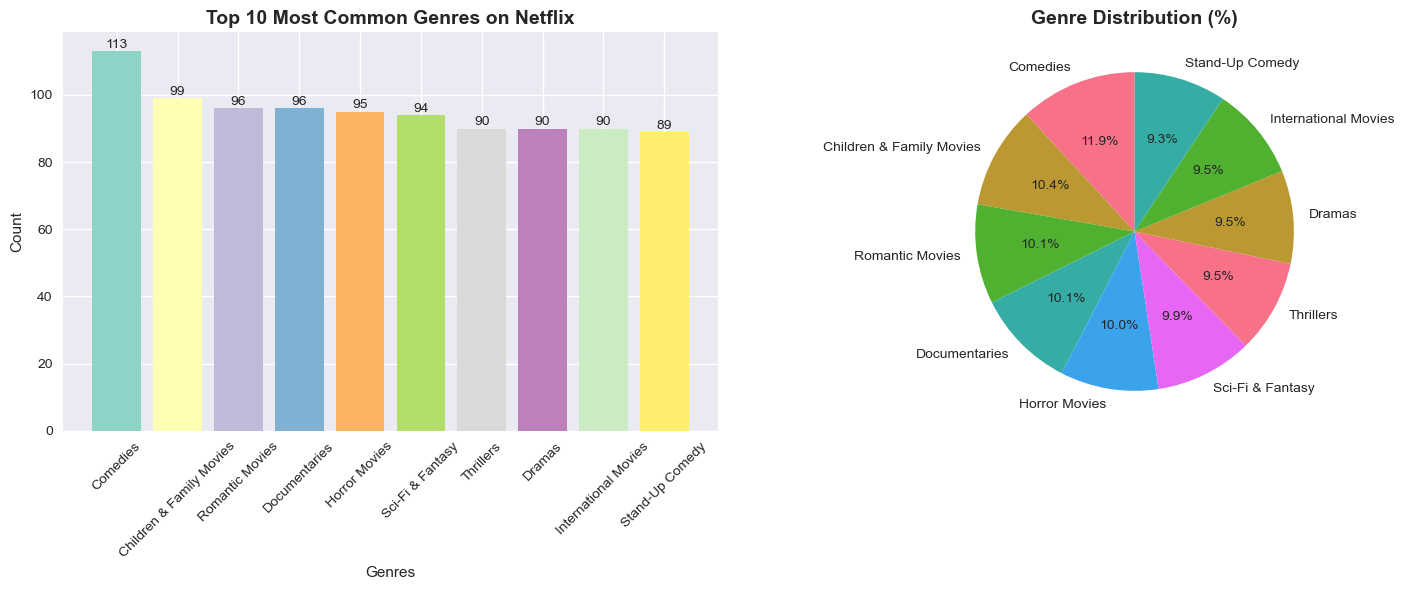

Top 10 genres:
  Comedies: 113
  Children & Family Movies: 99
  Romantic Movies: 96
  Documentaries: 96
  Horror Movies: 95
  Sci-Fi & Fantasy: 94
  Thrillers: 90
  Dramas: 90
  International Movies: 90
  Stand-Up Comedy: 89

Analyzing ratings from column: rating


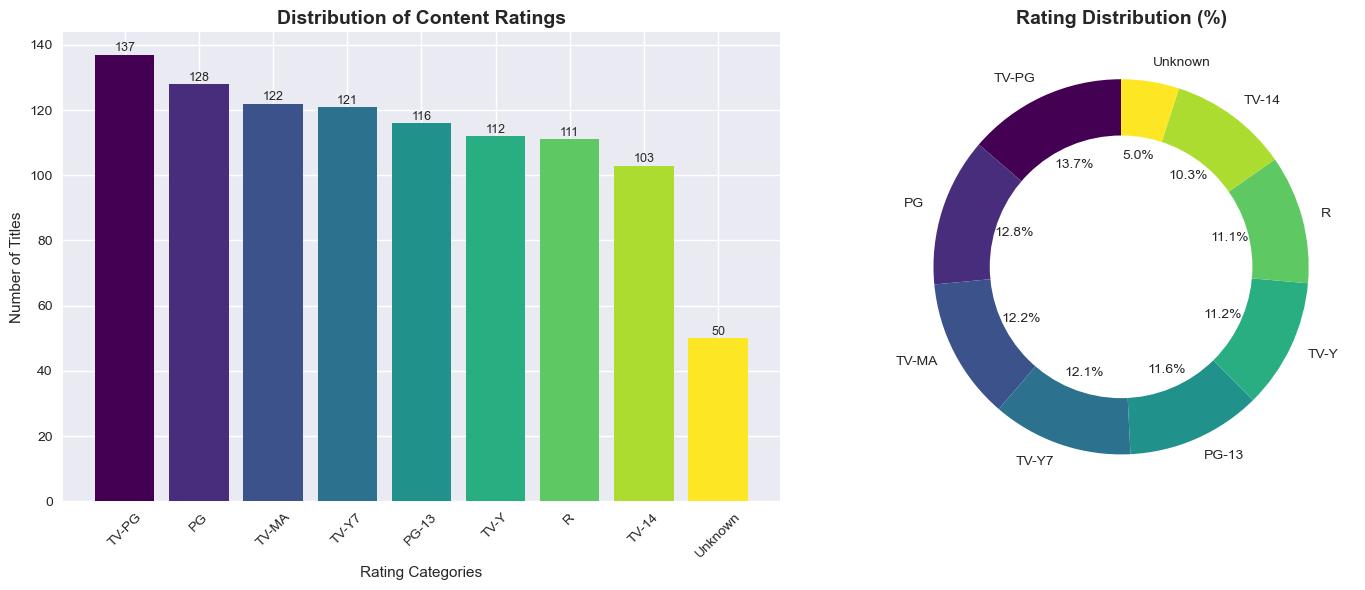

Rating distribution:
  TV-PG: 137
  PG: 128
  TV-MA: 122
  TV-Y7: 121
  PG-13: 116
  TV-Y: 112
  R: 111
  TV-14: 103
  Unknown: 50


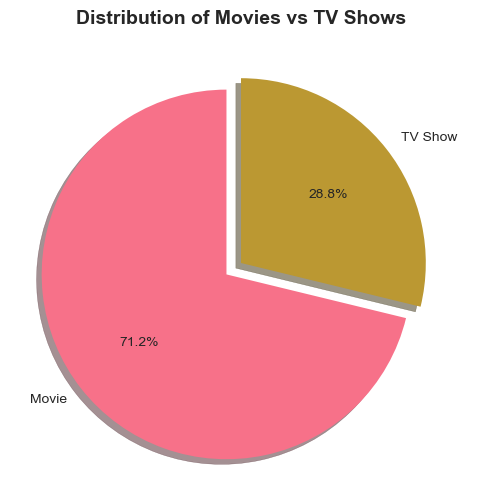

Type distribution:
  Movie: 712 (71.2%)
  TV Show: 288 (28.8%)

Sample analysis completed! Use this code with your actual Netflix dataset.


In [19]:
def main():
    """
    Main function to execute the entire analysis pipeline
    """
    print("Netflix Data Analysis Assignment")
    print("=" * 40)
    
    # Step 1: Data Preparation
    print("\nStep 1: Data Preparation")
    zip_file_path = "netflix_titles.csv.zip"  # Update this path as needed
    
    # If zip file doesn't exist, create a sample analysis with downloadable data
    if not os.path.exists(zip_file_path):
        print("Zip file not found. Creating sample analysis...")
        # We'll demonstrate with sample data structure
        sample_analysis()
        return
    
    df = unzip_and_load_data(zip_file_path)
    if df is None:
        print("Failed to load data. Exiting.")
        return
    
    df = rename_dataset(df, "Netflix_shows_movies")
    
    # Step 2: Data Cleaning
    print("\nStep 2: Data Cleaning")
    df_clean = clean_data(df)
    
    # Step 3: Data Exploration
    print("\nStep 3: Data Exploration")
    numerical_cols, categorical_cols = explore_data(df_clean)
    
    # Step 4: Column Detection
    print("\nStep 4: Column Detection")
    column_mapping = detect_netflix_columns(df_clean)
    
    # Step 5: Data Visualization
    print("\nStep 5: Data Visualization")
    create_visualizations(df_clean, column_mapping)
    
    # Save cleaned dataset
    df_clean.to_csv("Netflix_shows_movies_cleaned.csv", index=False)
    print("\nCleaned dataset saved as 'Netflix_shows_movies_cleaned.csv'")
    
    print("\nAnalysis completed successfully!")

def sample_analysis():
    """
    Create sample analysis if actual data is not available
    """
    print("Creating sample analysis to demonstrate the workflow...")
    
    # Create sample Netflix-like data
    np.random.seed(42)
    n_samples = 1000
    
    sample_data = {
        'title': [f'Show_{i}' for i in range(n_samples)],
        'type': np.random.choice(['Movie', 'TV Show'], n_samples, p=[0.7, 0.3]),
        'genre': np.random.choice([
            'Dramas, International Movies',
            'Comedies',
            'Action, Adventure',
            'Documentaries',
            'Children & Family Movies',
            'Romantic Movies',
            'Thrillers',
            'Horror Movies',
            'Sci-Fi & Fantasy',
            'Stand-Up Comedy'
        ], n_samples),
        'rating': np.random.choice(['TV-MA', 'TV-14', 'PG-13', 'TV-PG', 'R', 'PG', 'TV-Y', 'TV-Y7'], n_samples),
        'release_year': np.random.randint(1990, 2023, n_samples),
        'duration': np.random.choice(['90 min', '120 min', '60 min', '45 min', '30 min'], n_samples)
    }
    
    df_sample = pd.DataFrame(sample_data)
    
    # Add some missing values to demonstrate cleaning
    for col in ['genre', 'rating']:
        missing_indices = np.random.choice(df_sample.index, size=int(n_samples*0.05), replace=False)
        df_sample.loc[missing_indices, col] = np.nan
    
    print("Sample dataset created with 1000 records")
    
    # Run the analysis pipeline on sample data
    df_clean = clean_data(df_sample)
    numerical_cols, categorical_cols = explore_data(df_clean)
    column_mapping = detect_netflix_columns(df_clean)
    create_visualizations(df_clean, column_mapping)
    
    df_clean.to_csv("Netflix_shows_movies_cleaned.csv", index=False)
    print("\nSample analysis completed! Use this code with your actual Netflix dataset.")

if __name__ == "__main__":
    main()